In [204]:
%load_ext autoreload
%autoreload 2

from tweedejaars_project import *
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
import matplotlib.pyplot as plt
from datetime import datetime

# TODO: False positives naar beneden halen
# TODO: validate cutoff?en andere optimalisatie technieken toepassen

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [205]:
features = [
    "import_capacity",
    "mid_price_published",
    "upward_dispatch_published",
    "downward_dispatch_published",
    'min_ptu_price_known',
    "max_ptu_price_known",
    "settlement_price_bestguess",
    'PTU',
    'forecast_wind',
    'forecast_solar',
    'forecast_demand',
    'time_since_last_two_sided',
    'two_sided_daily_count',
    'ptu_id',
    'naive_strategy_action',
    'minute_in_ptu',
    "hvq_delta",
    "residual_load",
    "dispatch_diff",
    "igcc_diff",
    "is_balanced",
    "weekday",
    "workday",
    "hour",
    "month",
    "day",
    "minute",

]
# already used
target = 'fix_two_sided_ptu_alt'

In [206]:
df = load_df()

In [207]:
def interpolate_feature(df, features):
    for feature in features:
        df[feature] = df[feature].ffill()  # TODO: kan misschien linear ipv fill maar idk hoe goed dat gaat werken met live data
    return df

# Fix rows for NaNs where it is allowed
df = interpolate_feature(df, ['forecast_wind', 'forecast_solar', 'forecast_demand', "upward_dispatch_published", "downward_dispatch_published", "vwap_avg",
 "forecast_wind_delta",
    "forecast_solar_delta",
    "forecast_demand_delta",
    "residual_load",
    "dispatch_diff",
    "igcc_diff",
    'hvq_delta'
])


In [208]:
def difference_published(df, features):
    values = [0., 1., 2., 3.]
    conditions = [
        (df[features[0]].notna() & df[features[1]].isna()),  # feature1 has value, feature2 is NaN
        (df[features[0]].isna() & df[features[1]].notna()),  # feature1 is NaN, feature2 has value
        (df[features[0]].isna() & df[features[1]].isna()),   # both feature1 and feature2 are NaN
        (df[features[0]].notna() & df[features[1]].notna())  # both feature1 and feature2 have values
    ]
    df['publish_info'] = np.select(conditions, values)
    return df

# bool ipv 2 feature waardes
df = difference_published(df, ['min_price_published', 'max_price_published'])

In [209]:
def fill_vals_0(df, features):
    for feature in features:
        df[feature] = df[feature].fillna(0)
    
    return df

df = fill_vals_0(df, ['min_ptu_price_known', 'max_ptu_price_known', 'settlement_price_bestguess'])


In [211]:
input_size = len(features)  # Features
hidden_size = 2
num_layers = 2
output_size = 1
seq_length = 15  # 15 voor ptu_window dus 15 rows 
batch_size = seq_length * 15
num_epochs = 2
learning_rate = 0.001
patience = int(num_epochs * 0.75)


splits = get_splits(df, features, target)
# Split the data in vars
train_data = splits['train']
valid_data = splits['valid']
test_data = splits['test']

In [212]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, lengths):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Initialize cell state with zeros
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Pack padded sequence
        packed_inputs = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        # Forward propagate LSTM
        out, _ = self.lstm(packed_inputs, (h0, c0))
        
        # Unpack packed sequence
        unpacked_output, _ = pad_packed_sequence(out, batch_first=True)
        
        # Decode the hidden state of the last time step
        out = self.fc(unpacked_output[:, -1, :])  # out: tensor of shape (batch_size, output_size)
        return out


In [213]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length, using_train, probability=0.25):
        self.data_in = pd.DataFrame(data['in']).astype(np.float32)
        self.data_out = pd.Series(data['out']).astype(np.float32)
        self.seq_length = seq_length
        self.using_train = using_train
        self.probability = probability

    def __len__(self):
        return len(self.data_in)

    def __getitem__(self, idx):
        # if self.using_train:
        #     if not self.data_out.iloc[max(0, idx - self.seq_length + 1):idx + 1].any(): # er is geen True
        #             if np.random.rand() >= self.probability: # als groter dan prob dan toch deleten dus bijv 25% kans om te houden bij 0.25 prob
        #                 return torch.empty(0), torch.empty(0), 0

        # Extract a sequence of length seq_length or truncate if at the start
        if idx + 1 >= self.seq_length:
            sequence = self.data_in.iloc[idx - self.seq_length + 1:idx + 1].values
        else:
            sequence = self.data_in.iloc[:idx + 1].values

        target = self.data_out.iloc[idx]
        return torch.tensor(sequence, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)
    

def collate_fn(batch):
    # Filter out empty tensors
    batch = [item for item in batch if item[0].numel() > 0]

    if len(batch) == 0:
        return torch.empty(0), torch.empty(0), []


    sequences, targets = zip(*batch)
    lengths = [len(seq) for seq in sequences]
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
    return padded_sequences, torch.stack(targets), lengths

# TODO: DUBBELCHECK MIJ, Maar als het goed is komt target overeen met de laastste row

In [214]:
# dataset = TimeSeriesDataset(train_data, seq_length)

# for i in range(len(dataset)):
#     sequence, target = dataset[i]
#     print(f"Index {i}: Sequence length {len(sequence)}, \nTarget {target}, \nLast sequence value {sequence[-1]}")


In [215]:
def prepare_data_loader(data, seq_length, batch_size, train=False):
    dataset = TimeSeriesDataset(data, seq_length, train)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Assuming you have splits like train_data, valid_data, test_data
train_loader = prepare_data_loader(train_data, seq_length, batch_size, train=True)
valid_loader = prepare_data_loader(valid_data, seq_length, batch_size)
test_loader = prepare_data_loader(test_data, seq_length, batch_size)

print(f'expected batches training: {len(train_loader)}')
print(f'expected batches validation: {len(valid_loader)}')
print(f'expected batches testing: {len(test_loader)}')

expected batches training: 551
expected batches validation: 186
expected batches testing: 243


In [216]:
def train(model, train_loader, valid_loader, optimizer, criterion, num_epochs, device, scheduler=None, patience=10):

    train_losses = []
    valid_losses = []
    best_valid_loss = float('inf')
    best_model_state_dict = None
    epochs_no_improve = 0


    for epoch in range(num_epochs):
        model.train()

        train_loss = 0.0
        for i, (inputs, targets, lengths) in enumerate(train_loader):
            if len(inputs) == 0:  # Skip if batch is empty
                continue

            print(f"Training batch {i}, Sequence shape: {inputs.shape}, Lengths: {lengths}")
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs, lengths)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()

        # Calculate validation loss after every epoch
        valid_loss = evaluate(model, valid_loader, criterion, device)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss / len(train_loader):.4f}, Valid Loss: {valid_loss:.4f}')
        train_losses.append(train_loss/ len(train_loader))
        valid_losses.append(valid_loss)

        if scheduler:
            scheduler.step(valid_loss)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model_state_dict = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping after {epoch+1} epochs.')
                break

    # Reload the best model state
    print(f'Loading best model!')
    model.load_state_dict(best_model_state_dict)

    return train_losses, valid_losses


def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for i, (inputs, targets, lengths) in enumerate(data_loader):
            if len(inputs) == 0:  # Skip if batch is empty
                continue
            print(f"Validation batch {i}, Sequence shape: {inputs.shape}, Lengths: {lengths}")

            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs, lengths)
            loss = criterion(outputs.squeeze(), targets)
            total_loss += loss.item()
            
    return total_loss / len(data_loader)

In [217]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)

# WEIGHTING IS HIER
tensor_target = torch.tensor(train_data['out']).float()
criterion = nn.BCEWithLogitsLoss(pos_weight=(len(tensor_target)/ tensor_target.sum()*0.68))
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, amsgrad=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience)


train_losses, valid_losses = train(model, train_loader, valid_loader, optimizer, criterion, num_epochs, device, scheduler, patience)



Training batch 0, Sequence shape: torch.Size([225, 15, 27]), Lengths: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]
Training batch 1, Sequence shape: torc

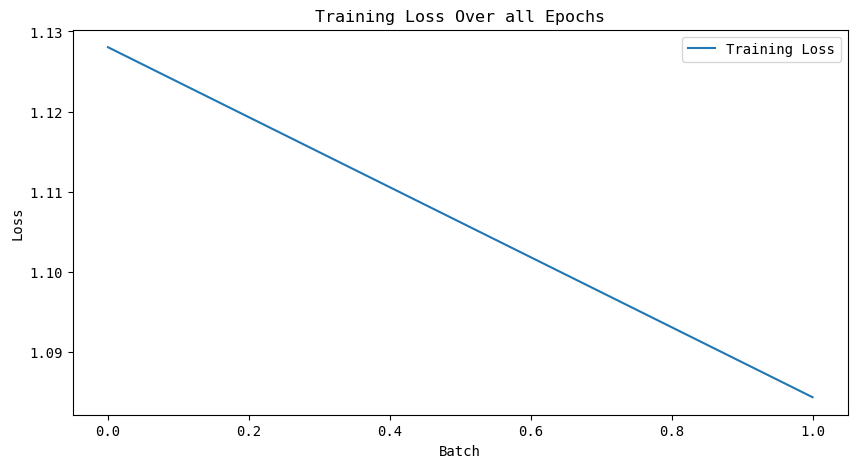

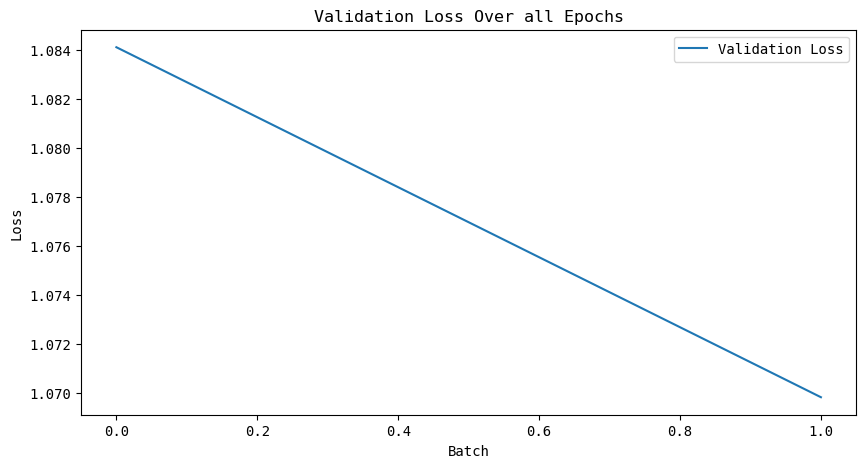

In [218]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss Over all Epochs')
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Validation Loss Over all Epochs')
plt.legend()
plt.show()

In [219]:
save_model(model, 'filtered_rnn', 'rnn')

In [220]:
def test(model, test_loader, criterion, device):

    all_outputs = []

    model.eval()
    
    test_loss = 0.0
    with torch.no_grad():
        for i, (inputs, targets, lengths) in enumerate(test_loader):
            if len(inputs) == 0:  # Skip if batch is empty
                continue
            print(f"Test batch {i}, Sequence shape: {inputs.shape}, Lengths: {targets.shape}")

            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs, lengths)
            
            loss = criterion(outputs.squeeze(), targets)
            test_loss += loss.item()

            all_outputs.append(outputs)

    print(f'Test Loss: {test_loss / len(test_loader):.4f}')
    return torch.cat(all_outputs)

outputs = test(model, valid_loader, criterion, device)


Test batch 0, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Size([225])
Test batch 1, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Size([225])
Test batch 2, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Size([225])
Test batch 3, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Size([225])
Test batch 4, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Size([225])
Test batch 5, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Size([225])
Test batch 6, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Size([225])
Test batch 7, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Size([225])
Test batch 8, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Size([225])
Test batch 9, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Size([225])
Test batch 10, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Size([225])
Test batch 11, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Si

In [221]:
probabilities = torch.sigmoid(outputs)
predictions = (probabilities > 0.5)

print(torch.sum(predictions))

tensor(14)


In [222]:
print(len(predictions), len(valid_data['df']))

41760 41760


In [223]:
unaltered_df = valid_data['df']
print(predictions)
print(sum(predictions))



tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])
tensor([14])


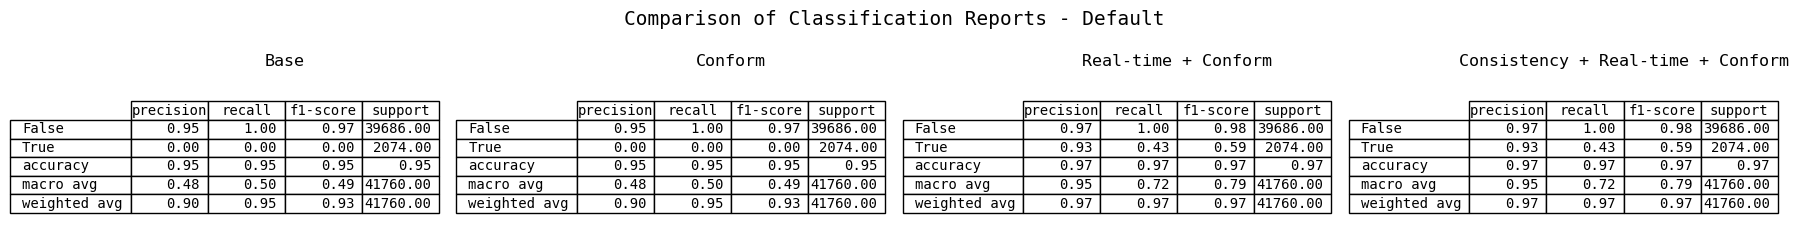

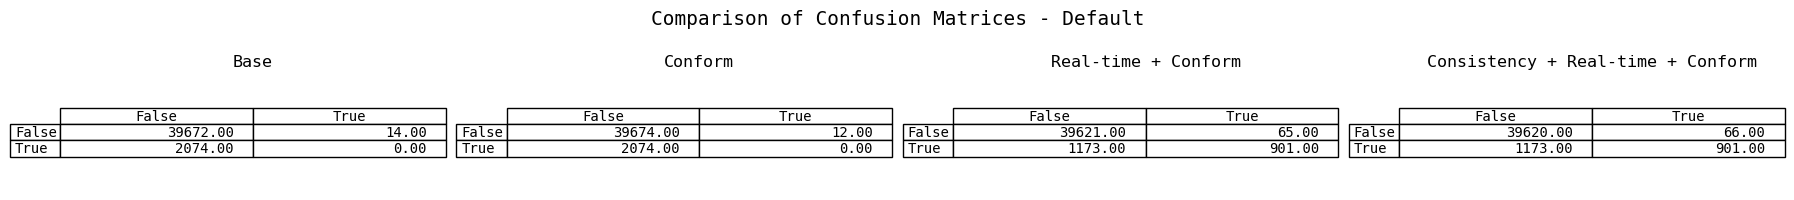

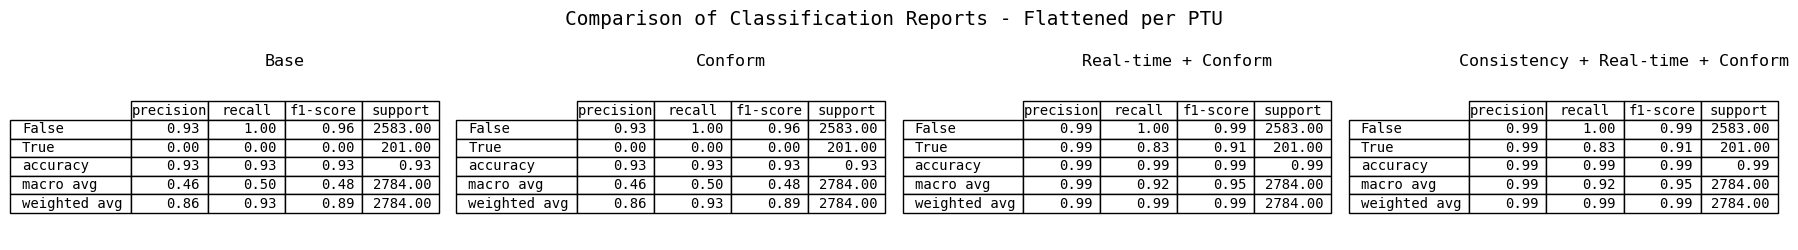

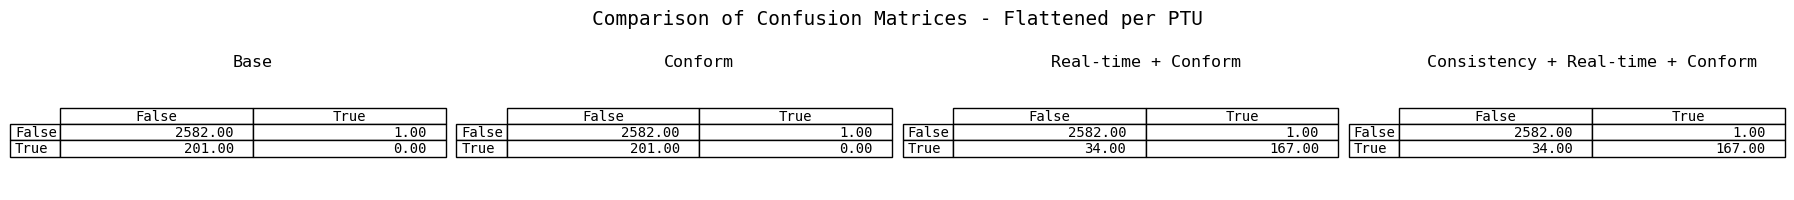

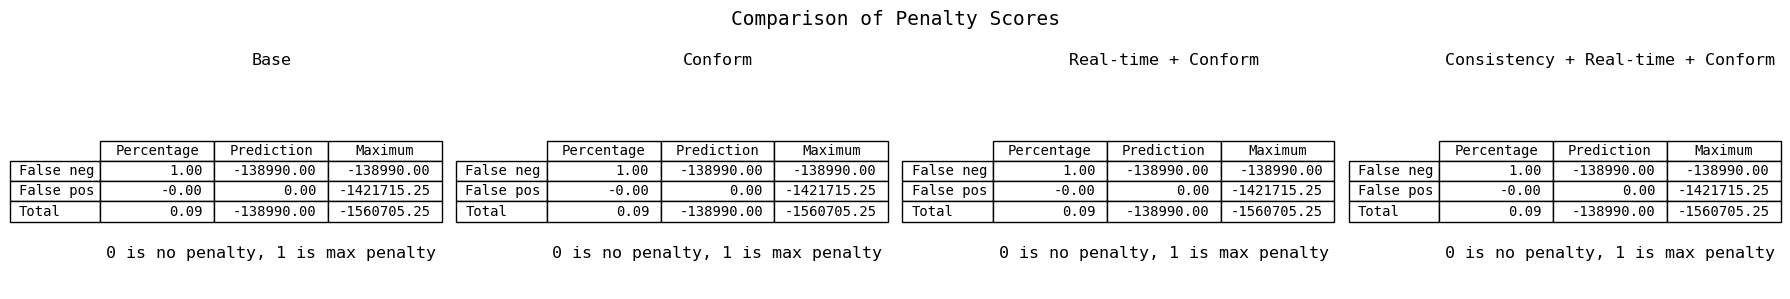

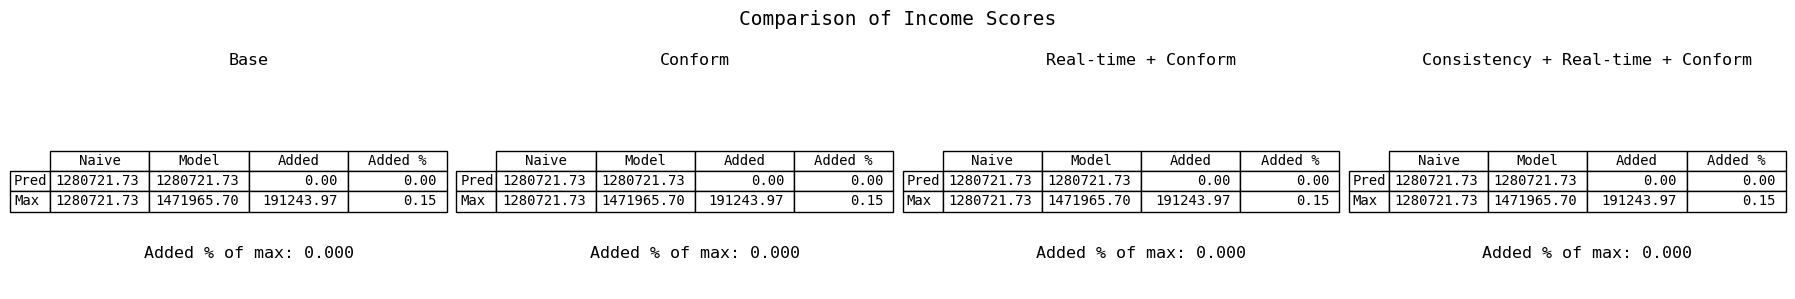

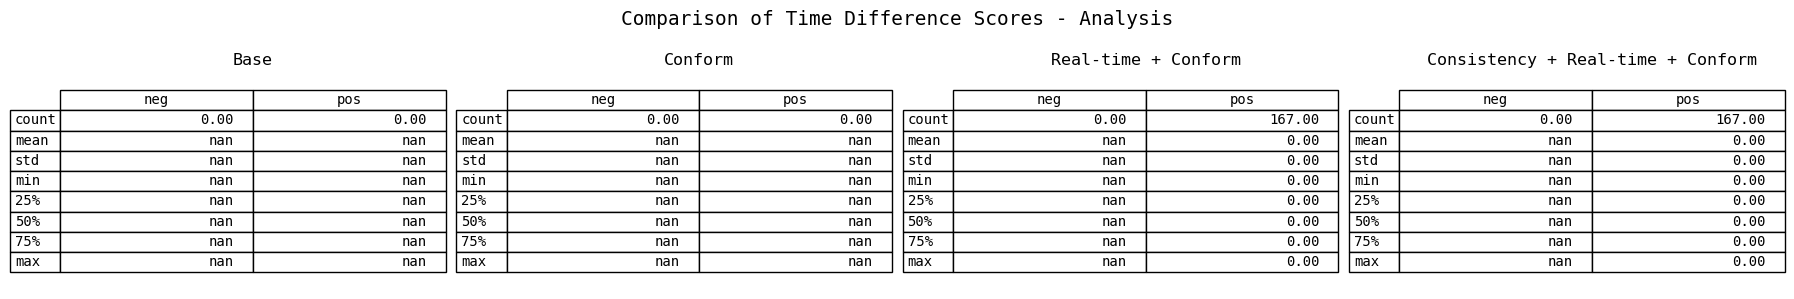

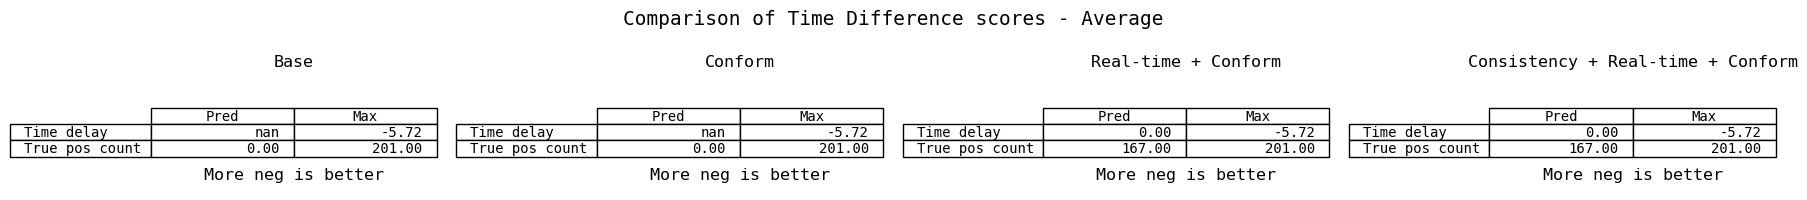

In [224]:
p1 = recast_pred(predictions.flatten()) # remake it into a series
show_metrics_adjusted(unaltered_df, p1)


Test batch 0, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Size([225])
Test batch 1, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Size([225])
Test batch 2, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Size([225])
Test batch 3, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Size([225])
Test batch 4, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Size([225])
Test batch 5, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Size([225])
Test batch 6, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Size([225])
Test batch 7, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Size([225])
Test batch 8, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Size([225])
Test batch 9, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Size([225])
Test batch 10, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Size([225])
Test batch 11, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Si

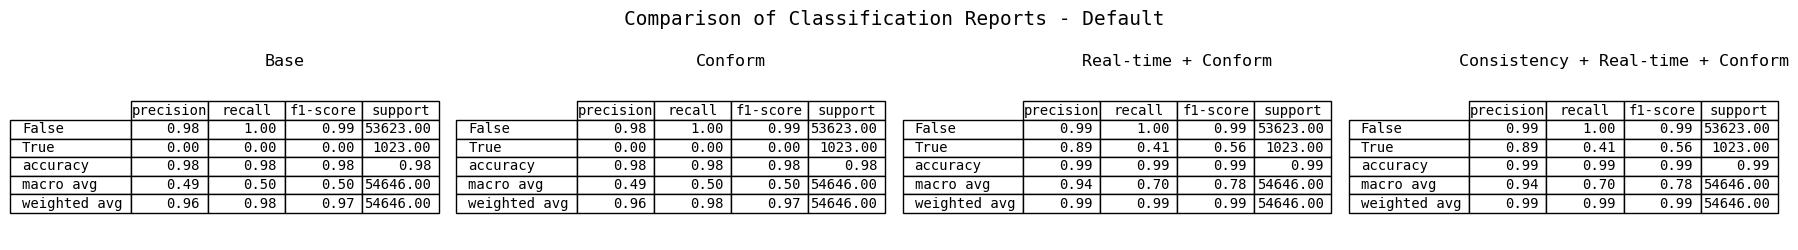

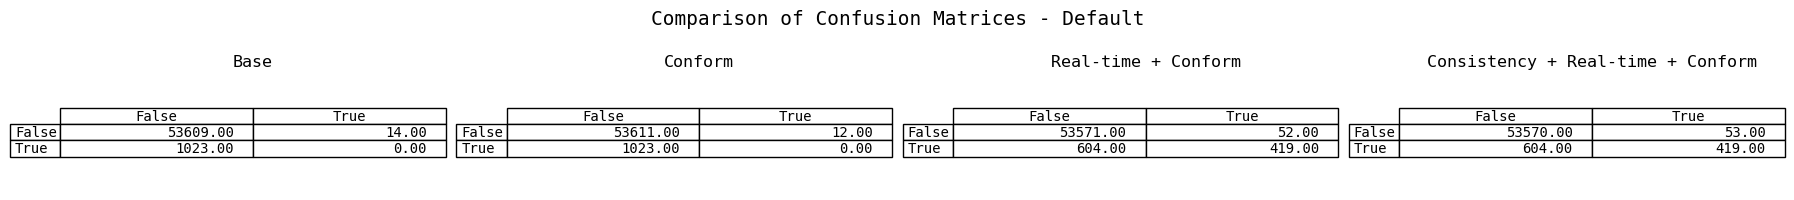

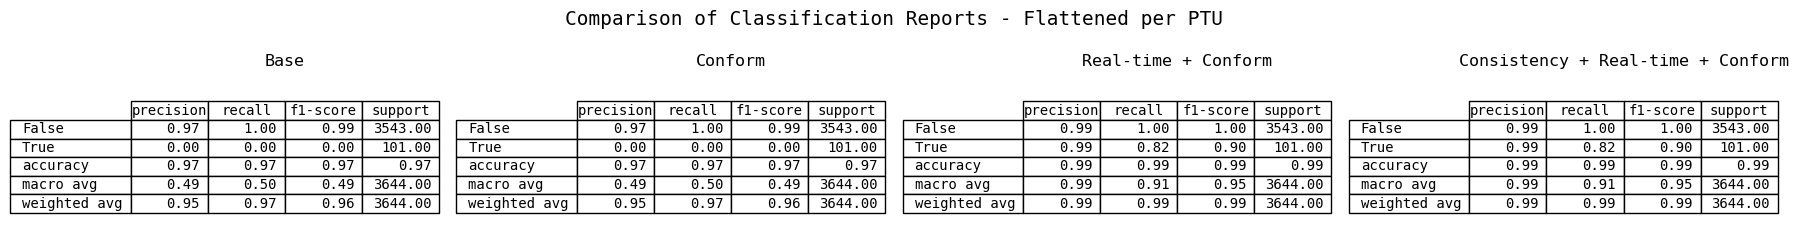

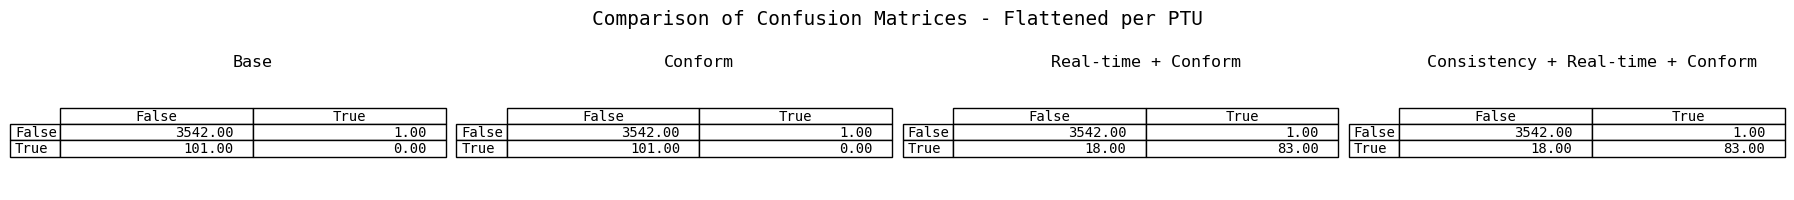

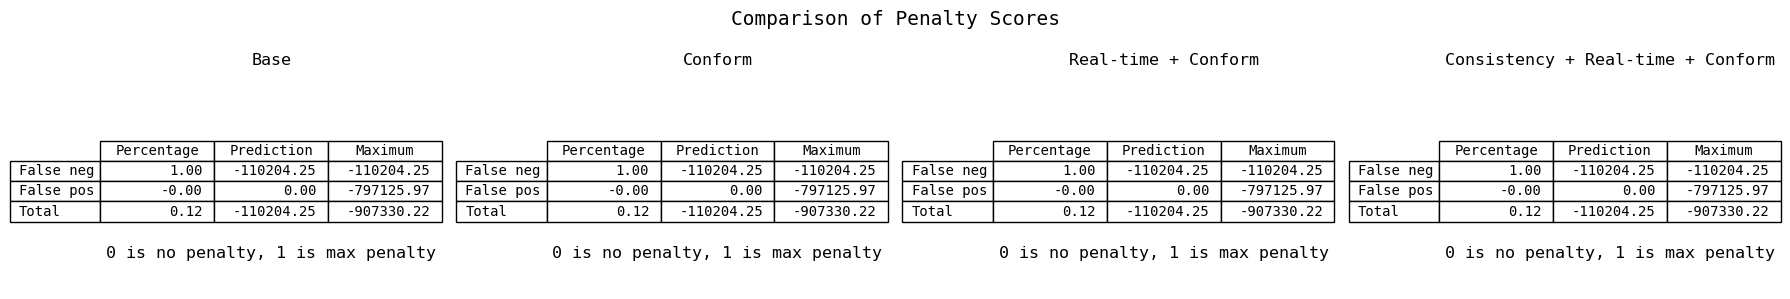

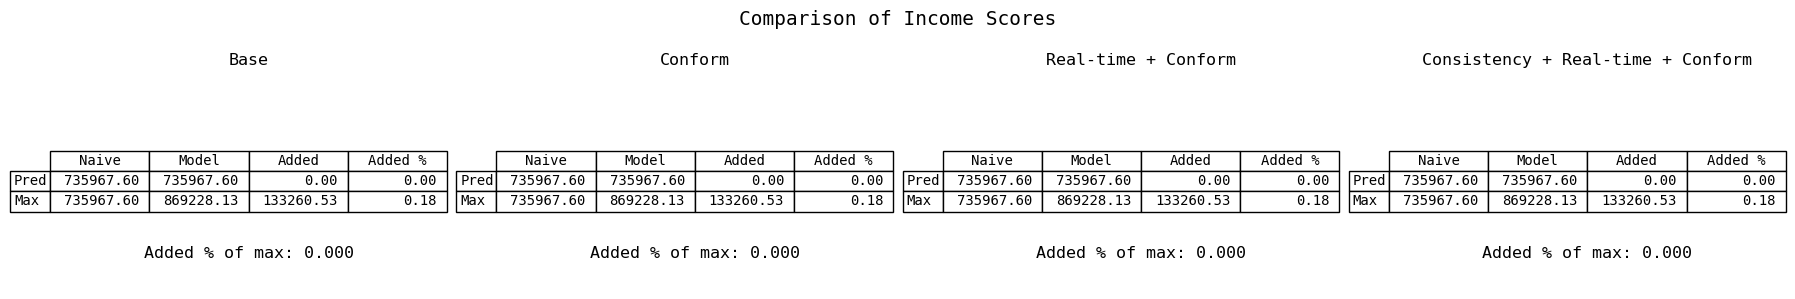

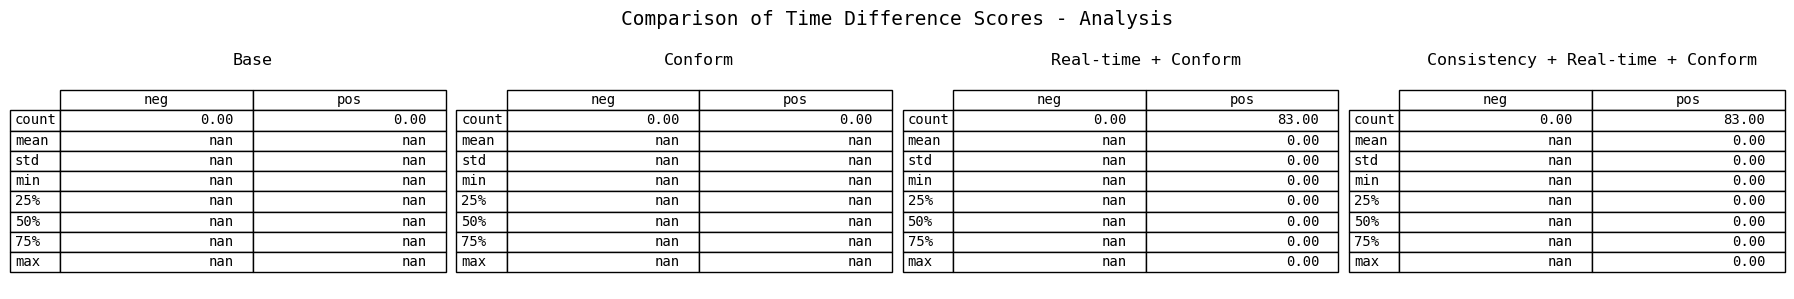

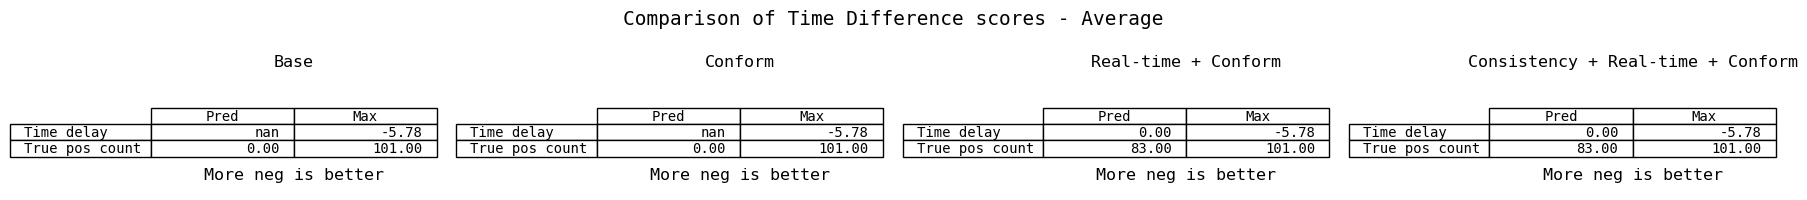

In [225]:
outputs_test = test(model, test_loader, criterion, device)
probabilities = torch.sigmoid(outputs_test)
predictions = (probabilities > 0.5)

print(torch.sum(predictions))

unaltered_df = test_data['df']
print(predictions)
print(sum(predictions))

p1 = recast_pred(predictions.flatten()) # remake it into a series
show_metrics_adjusted(unaltered_df, p1)




Test batch 0, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Size([225])
Test batch 1, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Size([225])
Test batch 2, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Size([225])
Test batch 3, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Size([225])
Test batch 4, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Size([225])
Test batch 5, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Size([225])
Test batch 6, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Size([225])
Test batch 7, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Size([225])
Test batch 8, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Size([225])
Test batch 9, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Size([225])
Test batch 10, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Size([225])
Test batch 11, Sequence shape: torch.Size([225, 15, 27]), Lengths: torch.Si

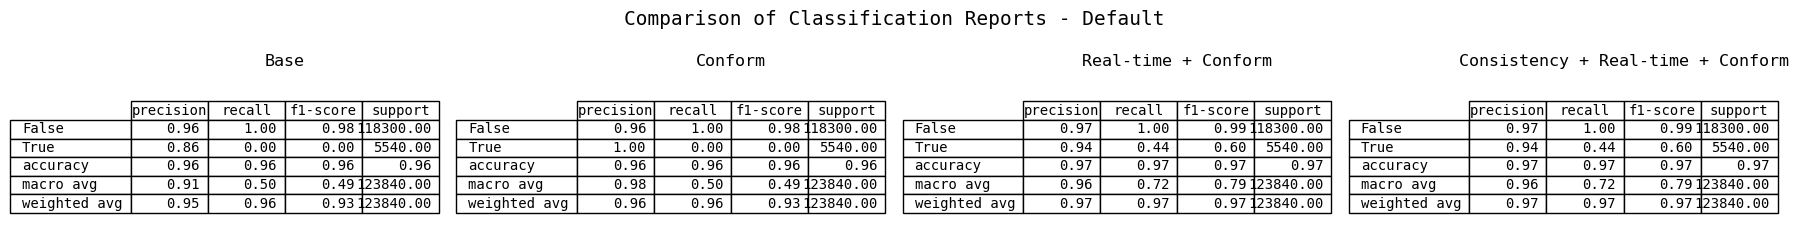

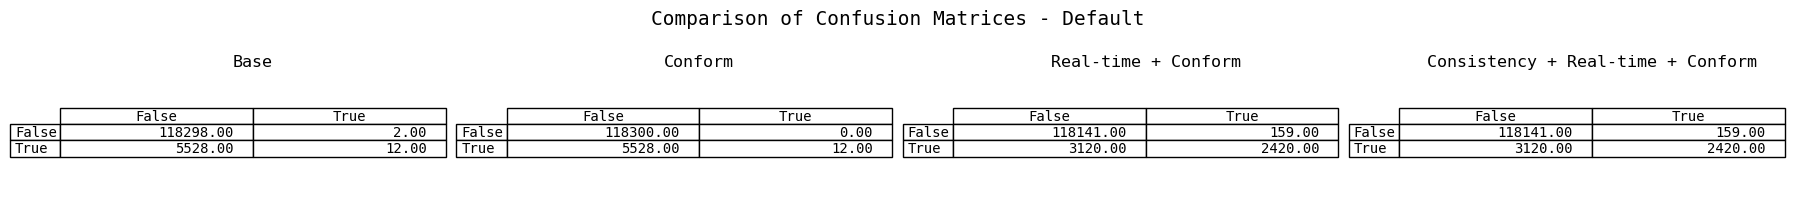

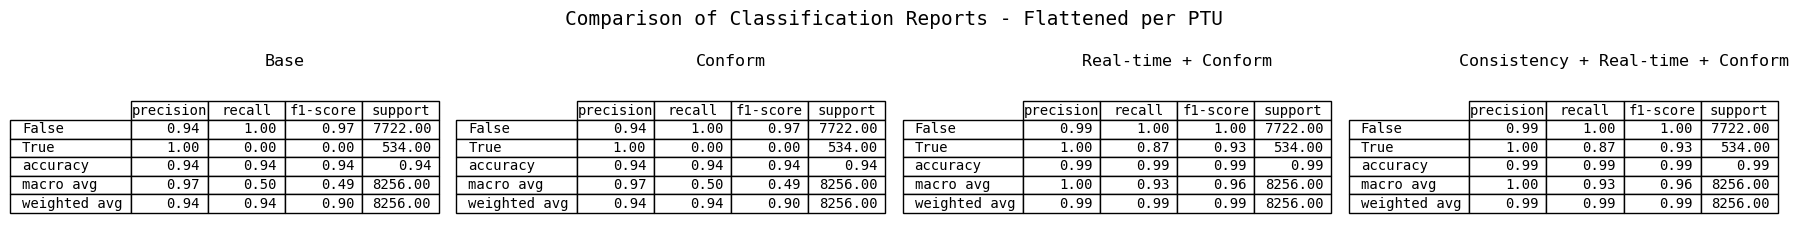

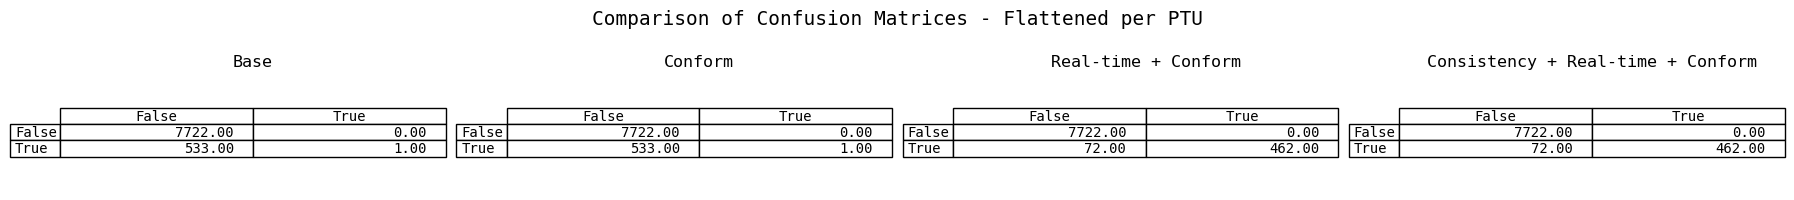

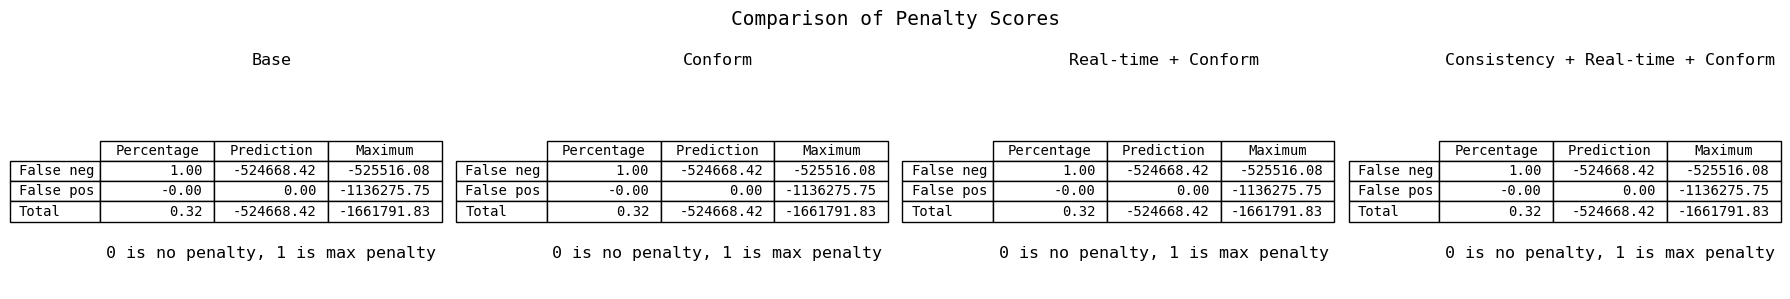

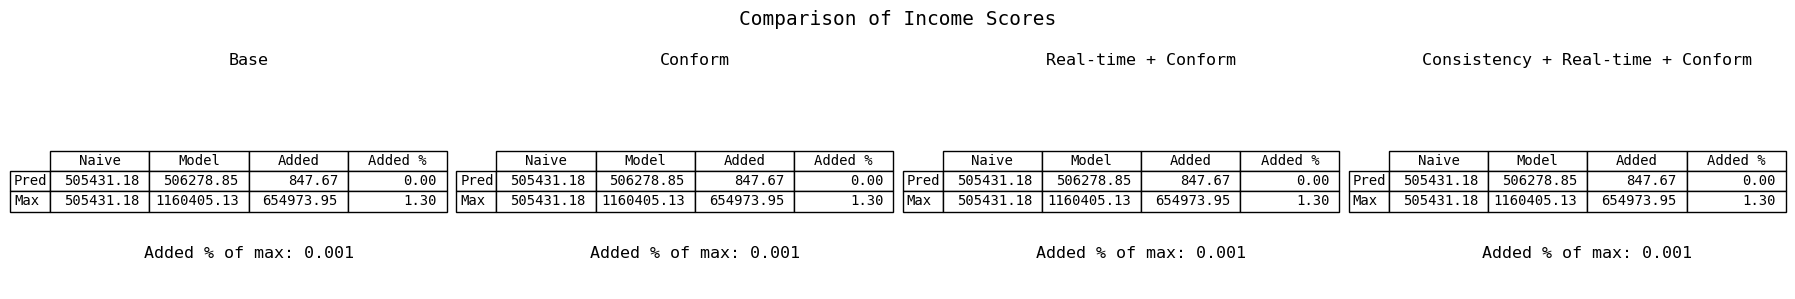

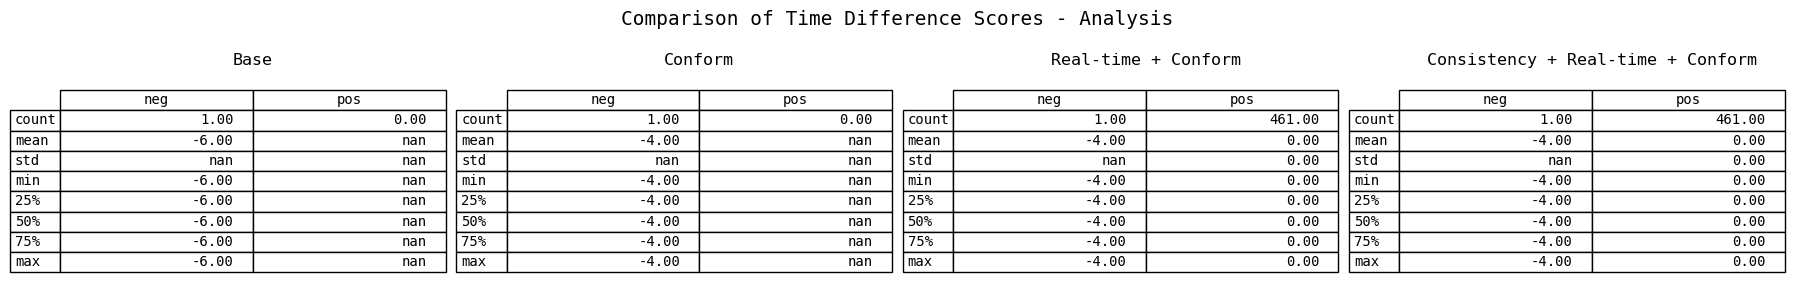

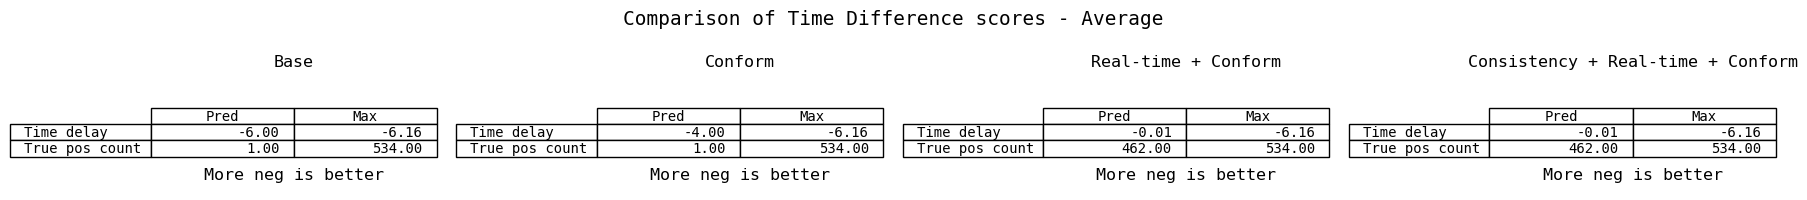

In [227]:
outputs_train = test(model, train_loader, criterion, device)
probabilities = torch.sigmoid(outputs_train)
predictions = (probabilities > 0.5)

print(torch.sum(predictions))

unaltered_df = train_data['df']
print(predictions)
print(sum(predictions))

p1 = recast_pred(predictions.flatten()) # remake it into a series
show_metrics_adjusted(unaltered_df, p1)


